# Summary

This notebook will explore the LMP data from the NYISO website.

Questions to answer:
- How is the congestion data distributed?
- How does congestion vary by year?
- How does congestion vary by month?
- What are the most congested pricing points?
- Which pricing points are traded the most in FTRs?

In [ ]:
import calendar
import datetime
import io
from zipfile import ZipFile

import geopandas as gpd
import gridstatus
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from adhoc_energy_analytics.constants import (
    get_default_download_dir,
    get_default_processed_dir,
)
from adhoc_energy_analytics.stats import freedman_diaconis_bins, trim_by_index

pd.set_option("display.float_format", "{:.5f}".format)
np.random.seed(42)


# subclass NYISO to override the _download_nyiso_archive method
class NYISOWithLocalZip(gridstatus.NYISO):

    # override init to set the download directory
    def __init__(self, *args, download_dir=None, **kwargs):
        if download_dir is None:
            download_dir = get_default_download_dir()
        self.download_dir = download_dir
        super().__init__(*args, **kwargs)

    def _download_nyiso_archive(
        self,
        date: str | pd.Timestamp,
        end: str | pd.Timestamp | None = None,
        dataset_name: str | None = None,
        filename: str | None = None,
        groupby: str | None = None,
        verbose: bool = False,
    ):
        """
        Override to prevent downloading from NYISO's website.
        Instead, we will read from a pre-downloaded zip file.
        """
        if filename is None:
            filename = dataset_name

        # NB: need to add the file date to the load forecast dataset to get the
        # forecast publish time.
        add_file_date = gridstatus.nyiso.LOAD_FORECAST_DATASET == dataset_name

        date = gridstatus.utils._handle_date(date, self.default_timezone)
        month = date.strftime("%Y%m01")
        day = date.strftime("%Y%m%d")

        # NB: if requesting the same day then just download the single file
        if end is not None and date.normalize() == end.normalize():
            end = None
            date = date.normalize()

        # NB: the last 7 days of file are hosted directly as csv
        # todo this can probably be optimized to a single csv in
        # a range and all files are in the last 7 days
        if end is None and date > pd.Timestamp.now(
            tz=self.default_timezone,
        ).normalize() - pd.DateOffset(days=7):
            raise NotImplementedError()
        else:
            # Get files from download dir
            zip_url = self.download_dir / f"{month}{filename}_csv.zip"
            if verbose:
                print(f"Reading from {zip_url}")
            with open(zip_url, "rb") as f:
                z = ZipFile(io.BytesIO(f.read()))

            all_dfs = []
            if end is None:
                date_range = [date]
            else:
                date_range = pd.date_range(
                    date.date(),
                    end.date(),
                    freq="1D",
                    inclusive="left",
                ).tolist()

                # NB: this handles case where end is the first of the next month
                # this pops up from the support_date_range decorator
                # and that date will be handled in the next month's zip file
                if end.month == date.month:
                    date_range += [end]

            for d in date_range:
                d = gridstatus.utils._handle_date(d, tz=self.default_timezone)
                month = d.strftime("%Y%m01")
                day = d.strftime("%Y%m%d")

                csv_filename = f"{day}{filename}.csv"
                if csv_filename not in z.namelist():
                    print(f"{csv_filename} not found in {zip_url}")
                    continue
                df = pd.read_csv(z.open(csv_filename))

                if add_file_date:
                    # NB: The File Date is the last modified time of the individual csv file
                    df["File Date"] = pd.Timestamp(
                        *z.getinfo(csv_filename).date_time,
                        tz=self.default_timezone,
                    )
                df = self._handle_time(df, dataset_name, groupby=groupby)

                # The column 'Marginal Cost Congestion ($/MWH' might exist,
                # in which case we need to add an ending 'r)'
                if "Marginal Cost Congestion ($/MWH" in df.columns:
                    df.rename(
                        columns={
                            "Marginal Cost Congestion ($/MWH": "Marginal Cost Congestion ($/MWHr)"
                        },
                        inplace=True,
                    )

                all_dfs.append(df)
            df = pd.concat(all_dfs)
        return df.sort_values("Time").reset_index(drop=True)


nyiso = NYISOWithLocalZip(download_dir=get_default_download_dir())

# Setup

Download the NYISO LMP data for the past N years.

In [3]:
def download_lmp_by_month(
    start_date: datetime.date, end_date: datetime.date
) -> pd.DataFrame:
    """
    Download NYISO LMP data one month at a time between start_date and end_date.
    Each month's data is saved as a separate parquet file in the default processed dir.
    Returns a concatenated DataFrame of all months.
    """
    processed_dir = get_default_processed_dir()
    processed_dir.mkdir(parents=True, exist_ok=True)

    current = datetime.date(start_date.year, start_date.month, 1)
    last = datetime.date(end_date.year, end_date.month, 1)

    dfs = []
    while current <= last:
        next_month = current + relativedelta(months=1)
        month_end = next_month - datetime.timedelta(seconds=1)

        out_path = processed_dir / f"nyiso_lmp_{current:%Y_%m}.parquet"
        if out_path.exists():
            print(f"Loading existing file {out_path}")
            df_month = pd.read_parquet(out_path)
        else:
            print(f"Downloading LMP data for {current:%Y-%m} to {out_path}")
            df_month = nyiso.get_lmp(
                date=current,
                end=month_end,
                market=gridstatus.Markets.DAY_AHEAD_HOURLY,
                locations="ALL",
                location_type=gridstatus.nyiso.GENERATOR,
                verbose=True,
            )
            df_month.to_parquet(out_path)

        dfs.append(df_month)
        current = next_month

    print(f"Concatenating {len(dfs)} months of data")
    return pd.concat(dfs, ignore_index=True).astype(
        {"Market": "category", "Location": "category", "Location Type": "category"}
    )


# example invocation
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2025, 1, 1) - datetime.timedelta(days=1)
df = download_lmp_by_month(start_date, end_date)

Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_01.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_02.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_03.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_04.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_05.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_06.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_07.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_08.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2010_09.parquet
L

# How is the congestion data distributed?

Congestion is heavily skewed to the right, with more than 50% of values being less than 1.

In [3]:
df.Congestion.describe()

count   72494267.00000
mean           6.95510
std           17.76771
min         -823.22000
25%           -0.00000
50%            0.38000
75%            6.92000
max         2210.33000
Name: Congestion, dtype: float64

In [6]:
trimmed_df = trim_by_index(df, trim_col="Congestion", lower_pct=0.1, upper_pct=0.1)
trimmed_vals = trimmed_df.Congestion

In [5]:
trimmed_vals.describe()

count   57995414.00000
mean           3.15163
std            4.77294
min           -0.00000
25%            0.00000
50%            0.38000
75%            4.86000
max           19.68000
Name: Congestion, dtype: float64

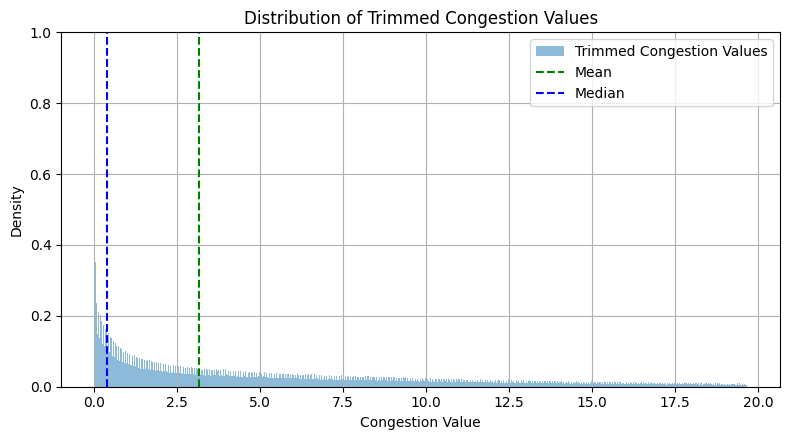

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Histogram of trimmed congestion values
bins = freedman_diaconis_bins(trimmed_vals)
ax.hist(
    trimmed_vals, bins=bins, density=True, alpha=0.5, label="Trimmed Congestion Values"
)

# KDE overlay (takes too long to compute for large datasets)
# trimmed_vals.plot(kind="kde", ax=ax, color="red", linewidth=1, label="KDE", alpha=0.7)

# Mean & median lines
ax.axvline(trimmed_vals.mean(), color="green", linestyle="dashed", label="Mean")
ax.axvline(trimmed_vals.median(), color="blue", linestyle="dashed", label="Median")

# Axis limits, labels, title, legend, grid
ax.set_ylim(0, 1)
ax.set_title("Distribution of Trimmed Congestion Values")
ax.set_xlabel("Congestion Value")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

# How does congestion vary by year?

There was a significant increase in congestion starting around 2021, lasting through mid-2023. The reasons for congestion varied by year and highlights how many factors can contribute to congestion. The main reasons I could find for increased congestion revenues in the above timeframe are:
* Gas prices contributed to price spreads between regions, which increased redispatch costs to resolve congestion.
* Transmission outages to facilitate public policy projects
* Retirement of Indian Point nuclear station
* Transmission outages on tie lines between Long Island and upstate regions

In **2021**, congestion increased because of higher redispatch costs due to increased gas prices, bottlenecks from transmission upgrades, the [Indian Point nuclear station](https://en.wikipedia.org/wiki/Indian_Point_Energy_Center) retirement on April 30 and tie line outages. From the [2021 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2022/05/NYISO-2021-SOM-Full-Report_5-11-2022-final.pdf):

> Real-time prices varied from an average of $24.10 per MWh in the North Zone to $62.24 per MWh in Long Island in 2021 because of the effects of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2020 to 2021, up 72 to 78 percent in Western New York and 92 to 104 percent in Eastern New York. The increases across the system were driven primarily by higher natural gas prices. The larger increase in Eastern New York was mostly attributable to more severe transmission bottlenecks across the Central-East interface because of lengthy transmission outages taken to facilitate several Public Policy Transmission Projects and the retirements of Indian Point nuclear units. In addition, Long Island experienced lengthy transmission outages on both of its tie lines with upstate regions, leading to abnormally high levels of congestion and elevated energy prices on Long Island.
> 
> Consequently, congestion revenues collected in the day-ahead market rose 86 percent from 2020, totaling $551 million in 2021. (See Section VI.A) The following corridors accounted for most of the congestion in 2021:
> * Central-East Interface – 56 percent
> * Long Island – 12 percent
> * West Zone (flowing east) – 9 percent
> * North to Central New York – 6 percent
> * New York City – 6 percent

From section II.A of the report:

> Transmission congestion increased on paths from north-to-central New York, from central-to-eastern New York, and from upstate into Long Island. These increases were driven primarily by lengthy planned policy-driven transmission outages, the Indian Point 3 retirement at the end of April, and forced outages of key transmission lines during the summer months (especially into Long Island).

From section VII of the report:
> Higher natural gas prices and gas price spreads between regions, which increase redispatch costs to resolve congestion, were one of the main drivers of elevated congestion levels in 2021.

In **2022**, congestion rose *again* due to higher gas prices and more lengthy transmission outages for AC public policy projects.

From the [2022 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2023/05/NYISO-2022-SOM-Full-Report__5-16-2023-final.pdf):

> Real-time prices varied from an average of $50.46 per MWh in the North Zone to $108 per MWh in Long Island in 2022 because of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2021 to 2022, up 83 to 109 percent in Western New York and 73 to 126 percent in Eastern New York, primarily because of higher natural gas prices. The larger increases in eastern New York was largely attributable to: (a) more severe transmission bottlenecks across the Central-East interface due to lengthy transmission outages taken to facilitate the AC Public Policy Transmission Projects, and (b) larger gas price increases in eastern New York during the winter months.
> Consequently, congestion revenues collected in the day-ahead market rose 82 percent from 2021, totaling $1 billion in 2022. (See Section VI.A) The following corridors accounted for most congestion in 2022:
> * Central-East Interface – 60 percent
> * External Interfaces – 9 percent
> * Long Island – 9 percent

More from section II.A of the report:

> Transmission congestion became more severe, especially from Central New York to East New York and from upstate into Long Island, primarily because of lengthy forced transmission outages and planned outages related to ongoing efforts to upgrade segments of the transmission system. More is written on congestion patterns in Section VII.

In **2023**, congestion fell because gas prices went down, and the transmission projects from 2021-2022 completed (thereby reducing outages) and as a result there was increased transmission capability. Also, the mild winter weather helped reduce congstion on gas pipelines.

From the [2023 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2024/05/NYISO-2023-SOM-Full-Report__5-13-2024-Final.pdf):

> Average energy prices fell substantially from 2022 in Western New York (53 to 57 percent) and Eastern New York (58 to 65 percent) mainly because of lower gas prices and fewer transmission outages. Transmission congestion and losses in 2023 caused real-time prices to vary from $23.50 per MWh in the North Zone to $45.38 in Long Island on average. (See Section II.A)
>
> Price reductions were larger in eastern New York because transmission bottlenecks across the Central-East interface were alleviated by: (a) fewer planned transmission outages related to construction of the AC Public Policy Transmission Projects, (b) the increased transfer capability from the newly-built projects, and (c) mild winter weather conditions which helped reduce congestion on gas pipelines flowing into eastern New York. Consequently, congestion revenues collected in the day-ahead market fell 69 percent from 2022, totaling $311 million in 2023. (See Section VI.A) Most congestion in 2023 occurred on two corridors: the Central-East Interface (53 percent of all congestion) and Long Island (19 percent of all congestion).

From section VII of the report:
> Day-ahead congestion revenues fell to $311 million in 2023, marking a 69 percent decrease from 2022 and nearing the lowest level observed ($297 million) over the past decade. The sharp reduction in congestion was primarily attributable to lower natural gas prices and narrower gas price spreads between regions, which led to lower redispatch costs.
>
> Congestion was also reduced by less frequent planned transmission outages in 2023 than during the construction of major transmission projects over the past two years. As major transmission upgrades have been completed, congestion in the affected regions has been greatly reduced.

... etc.

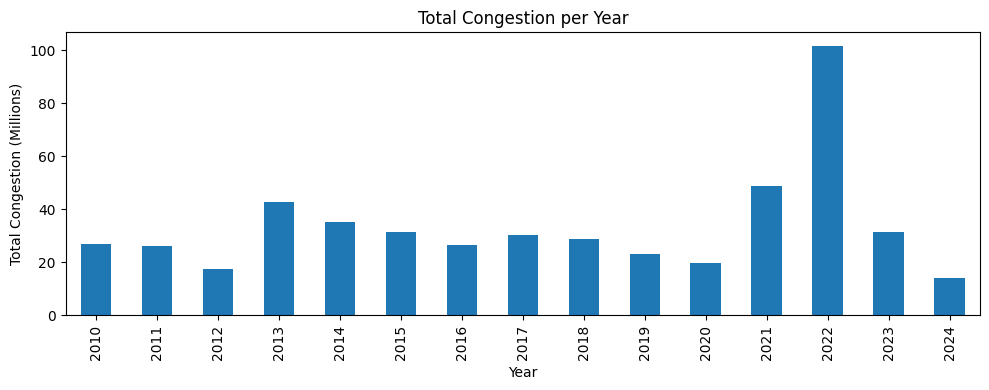

In [12]:
def plot_total_congestion_per_year(data, title):
    """
    Plots the total congestion per year for the given data.

    Parameters:
        data (pd.DataFrame): The DataFrame containing congestion data.
        title (str): The title for the plot.
    """
    yearly_totals = (
        data.groupby(data["Interval Start"].dt.year)["Congestion"].sum() / 1_000_000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    yearly_totals.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Congestion (Millions)")
    plt.tight_layout()
    plt.show()


plot_total_congestion_per_year(df, "Total Congestion per Year")

# How does congestion vary by month?

Congestion generally seems to be higher in the winter months, with the highest congestion in December and January, followed by February and March.

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_91666/2185635198.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data.groupby(data.Time.dt.to_period("M"))["Congestion"].sum() / 1_000_000


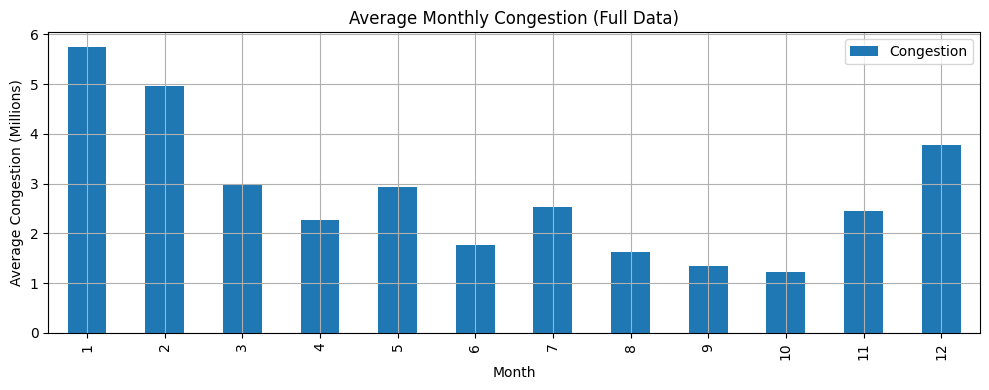

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_91666/2185635198.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data.groupby(data.Time.dt.to_period("M"))["Congestion"].sum() / 1_000_000


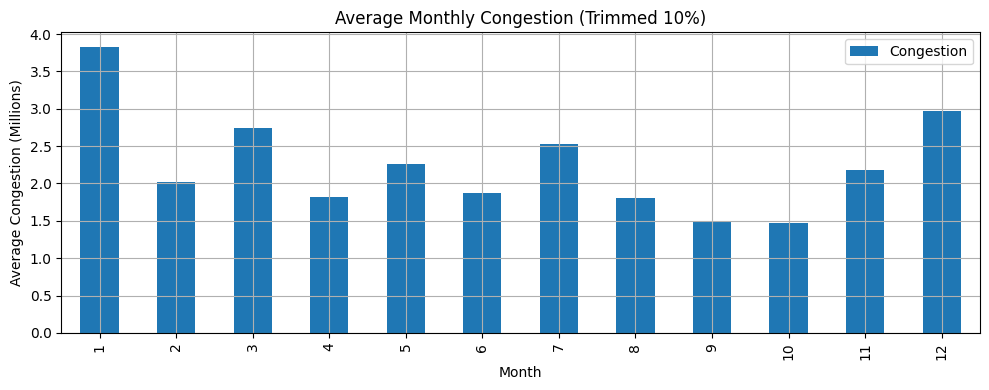

In [9]:
def plot_average_monthly_congestion(data, title, trim_pct=0.0):
    """
    Plots the average total monthly congestion (by month only, not by year) for the given data.

    Parameters:
        data (pd.DataFrame): The DataFrame containing congestion data.
        title (str): The title for the plot.
    """
    monthly_avg_congestion = (
        data.groupby(data.Time.dt.to_period("M"))["Congestion"].sum() / 1_000_000
    ).to_frame()
    trimmed = trim_by_index(
        monthly_avg_congestion,
        trim_col="Congestion",
        lower_pct=trim_pct,
        upper_pct=trim_pct,
    )
    trimmed.groupby(trimmed.index.month).mean().plot(
        kind="bar",
        figsize=(10, 4),
        title=title,
        xlabel="Month",
        ylabel="Average Congestion (Millions)",
        grid=True,
    )
    plt.tight_layout()
    plt.show()


plot_average_monthly_congestion(df, "Average Monthly Congestion (Full Data)")

plot_average_monthly_congestion(
    df, "Average Monthly Congestion (Trimmed 10%)", trim_pct=0.1
)

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_91666/3764012557.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data.groupby(data.Time.dt.to_period("M"))["Congestion"].sum() / 1_000_000


Average Winter Congestion: 4.83 million
Average Non-Winter Congestion: 2.13 million


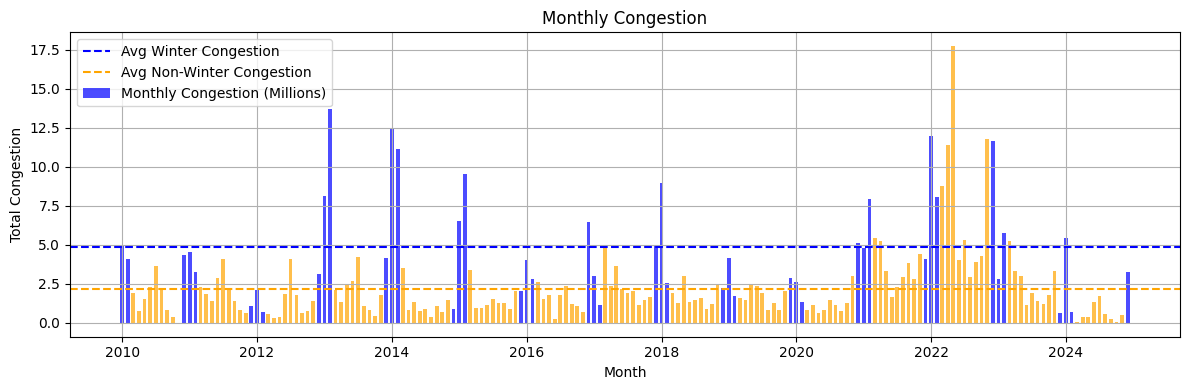

In [13]:
def plot_monthly_congestion(data, title, winter_months):
    """
    Plots monthly congestion with winter and non-winter averages.

    Parameters:
        data (pd.DataFrame): The DataFrame containing congestion data.
        title (str): The title for the plot.
        avg_winter (float): Average winter congestion.
        avg_non_winter (float): Average non-winter congestion.
        winter_months (list): List of winter months (e.g., [12, 1, 2]).
    """
    monthly_avg_congestion = (
        data.groupby(data.Time.dt.to_period("M"))["Congestion"].sum() / 1_000_000
    )  # Convert to millions
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.bar(
        monthly_avg_congestion.index.to_timestamp(),
        monthly_avg_congestion.values,
        color=[
            "blue" if m in winter_months else "orange"
            for m in monthly_avg_congestion.index.month
        ],
        label="Monthly Congestion (Millions)",
        alpha=0.7,
        width=20,
    )

    avg_winter = monthly_avg_congestion[
        monthly_avg_congestion.index.month.isin(winter_months)
    ].mean()
    avg_non_winter = monthly_avg_congestion[
        ~monthly_avg_congestion.index.month.isin(winter_months)
    ].mean()

    print(f"Average Winter Congestion: {avg_winter:.2f} million")
    print(f"Average Non-Winter Congestion: {avg_non_winter:.2f} million")

    ax.axhline(
        avg_winter, color="blue", linestyle="dashed", label="Avg Winter Congestion"
    )
    ax.axhline(
        avg_non_winter,
        color="orange",
        linestyle="dashed",
        label="Avg Non-Winter Congestion",
    )
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Total Congestion")
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()


winter_months = [12, 1, 2]  # December, January, February
plot_monthly_congestion(df, "Monthly Congestion", winter_months)

# What are the most congested pricing points?

* N.Y.C., Long Island, CAPITL and Hudson Valley have the highest sum congestion, with N.Y.C. and Long Island being the most congested by far.
* Other zones, such as NPX and PJM have lower sum congestion, but still a large proportion of hours are congested.

When trading FTRs, it would likely be best to focus on locations with high sum congestion and a high proportion of congested hours, such as N.Y.C. and Long Island.

In [24]:
# Load the NYISO generator nodes
generator_node_raw_df = pd.read_csv(
    "https://mis.nyiso.com/public/csv/generator/generator.csv"
)
generator_node_df = generator_node_raw_df[
    generator_node_raw_df.Active == "Y"
].set_index("Generator Name")
generator_node_df

,Generator PTID,Aggregation PTID,Subzone,Zone,Latitude,Longitude,Active
Generator Name,,,,,,,
59TH STREET_GT_1,24138,NaN,CON ED NY CITY,N.Y.C.,40.76612,-73.99611,Y
74TH STREET_GT_1,24260,NaN,CON ED NY CITY,N.Y.C.,40.76362,-73.94301,Y
74TH STREET_GT_2,24261,NaN,CON ED NY CITY,N.Y.C.,40.76362,-73.94301,Y
ADK HUDSON___FALLS,24011,NaN,NMPC CAPITAL,CAPITL,43.29007,-73.60607,Y
ADK RESOURCE___RCVRY,23798,NaN,NMPC CAPITAL,CAPITL,43.30615,-73.59195,Y
...,...,...,...,...,...,...,...
WSPRINGFIELD___10,2501,NaN,NPX-AC,NPX,NaN,NaN,Y
WYMAN HYDRO___1,185701,NaN,NPX-AC,NPX,NaN,NaN,Y
WYMAN HYDRO___2,185702,NaN,NPX-AC,NPX,NaN,NaN,Y


In [155]:
df_with_zone = df.join(
    generator_node_df[["Zone"]], on="Location", how="left"
)

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_10602/148787825.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stratified.groupby("Location")


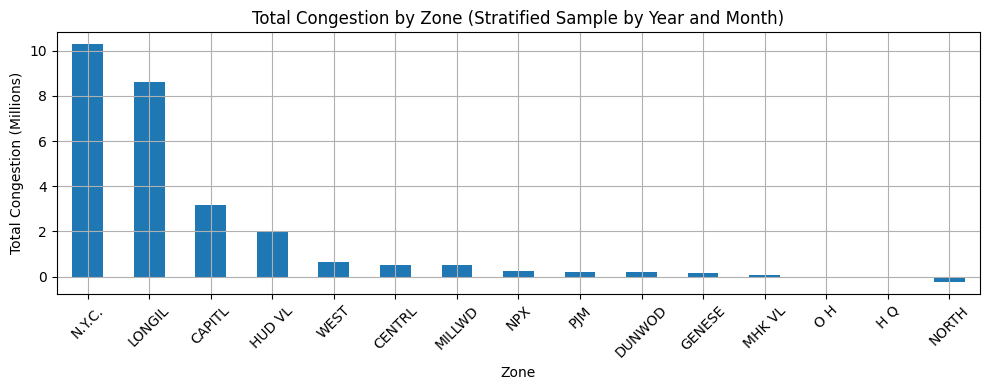

In [82]:
# Get a stratified sample of df by year AND month
df_stratified = df.groupby([df.Time.dt.year, df.Time.dt.month]).apply(
    lambda x: x.sample(n=int(250_000 / 12), random_state=42)
)

congestion_per_zone = (
    df_stratified.groupby("Location")
    .Congestion.sum()
    .to_frame()
    .join(generator_node_df)
    .groupby("Zone")
    .Congestion.sum()
    .div(1_000_000)
    .sort_values(ascending=False)
)

congestion_per_zone.plot(
    kind="bar",
    figsize=(10, 4),
    title="Total Congestion by Zone (Stratified Sample by Year and Month)",
    xlabel="Zone",
    ylabel="Total Congestion (Millions)",
    grid=True,
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [158]:
zone_year_grouped_df = df_with_zone.groupby(["Zone", df.Time.dt.year])

overall_counts = (
    zone_year_grouped_df["Congestion"].count().rename("Total Hours").to_frame()
)

congestion_counts = (
    zone_year_grouped_df["Congestion"]
    .apply(lambda x: (x > 0).sum())
    .rename("Congested Hours")
    .to_frame()
)

zone_year_congestion_percent_df = (
    congestion_counts.join(overall_counts, how="left")
    .assign(Congestion_Percent=lambda x: x["Congested Hours"] / x["Total Hours"] * 100)
    .reset_index()
)

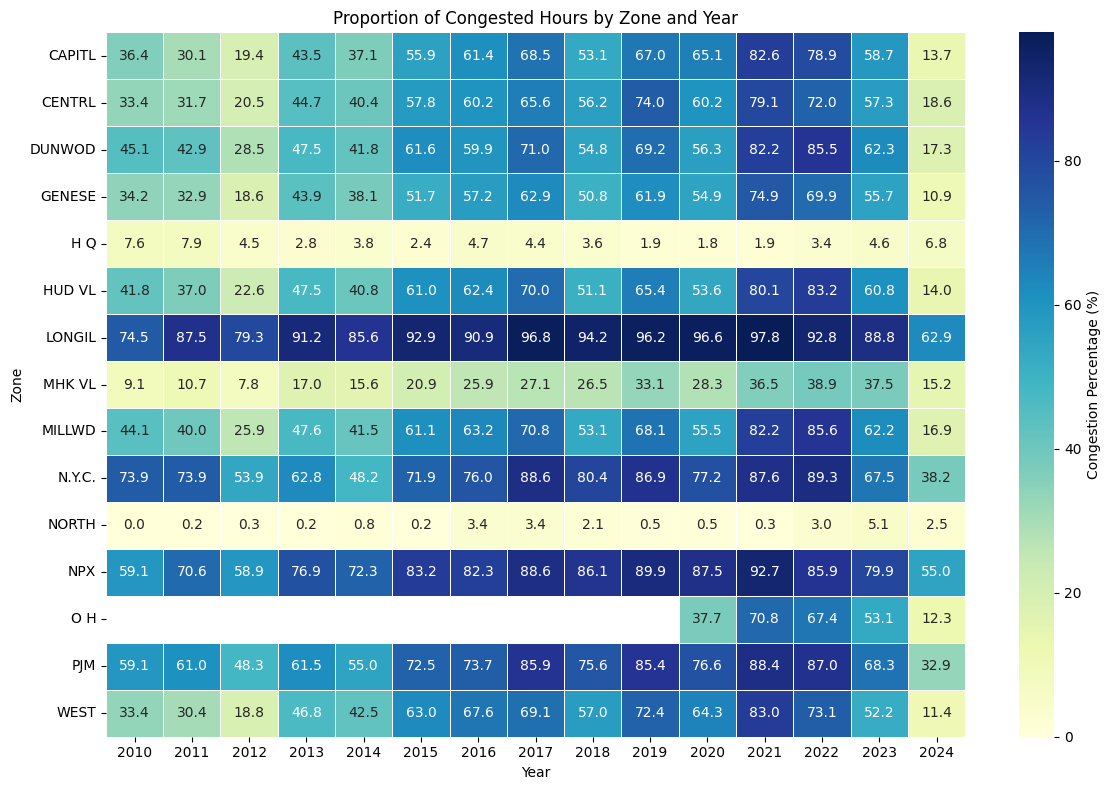

In [157]:
# Pivot the data for heatmap
heatmap_data = zone_year_congestion_percent_df.pivot(
    index="Zone", columns="Time", values="Congestion_Percent"
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Congestion Percentage (%)"},
)
plt.title("Proportion of Congested Hours by Zone and Year")
plt.xlabel("Year")
plt.ylabel("Zone")
plt.tight_layout()
plt.show()

# Which pricing points are traded the most in FTRs?